In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation

from scipy.sparse import diags
from scipy.sparse.linalg import inv 

In [2]:
# initial condition function 
def I(x):
    L = x[-1]
    len_x = np.size(x)
    i_x = np.zeros(len_x)
    for i in range(len_x):
        if x[i] < (L+1)/2 and x[i] > (L-1)/2:
            i_x[i] = 1
    return i_x

# exact solution
def U_exact(x, t):
    L = x[-1]
    u_ex = np.ones(np.size(x)) * (1/L)
    
    for n in range(1, 2000):
        c_n = (2 / (n * np.pi)) * (np.sin((n * np.pi * (L + 1)) / (2 * L)) - np.sin((n * np.pi * (L - 1)) / (2 * L)))
        
        u_ex += c_n * np.cos(n * np.pi * x / L) * np.exp(-1 * n ** 2 * np.pi ** 2 * t / L ** 2)
        
    return u_ex

In [3]:
# end length & end time
L=10; T=4

# diffusion coefficient 
a = 1

# setting up space part
Nx_spaces = 40 * L; Nt_gaps = 50 * T; 
Nx_points = Nx_spaces +  1 ; Nt_points = Nt_gaps + 1

x = np.linspace(0, L, Nx_points)
dx = x[1] - x[0]

# set up time part
t = np.linspace(0, T, Nt_points)
dt = t[1] - t[0]

# constant for numerical method
C = a * dt / dx ** 2
print("dx=",dx,"dt=", dt,"C =",C)

# set up matrices
u = np.zeros(Nx_points)
u_old = np.zeros(Nx_points)

U = np.zeros((Nx_points,Nt_points))
U_ex = np.zeros((Nx_points, Nt_points))

# Data structures for the linear system
b = np.zeros(Nx_points)

# set up the matrix A
A = diags([-C, 1 + 2 * C, -C], [-1, 0, 1], shape = (Nx_points, Nx_points))
A = A.toarray()
A[0, 1] = -2 * C
A[-1, -2] = -2 * C


dx= 0.025 dt= 0.02 C = 31.999999999999993


In [4]:
# define a sink term function 
def sink(x):
    return abs(0.1 * x)

In [5]:
# Set initial condition u(x,0) = I(x)
u_old = I(x) 

# initialise matrices U and U_ex2 for first time step
U[:,0] = u_old[:]
U_ex[:,0] = U_exact(x,0)

# perform time stepping
for n in range(1, Nt_points): # timestep for 1 to t = T-1 so last step finishes on t=T
    
    # Compute b and solve linear system
    b[:] = u_old[:]
    u[:] = np.linalg.solve(A, b)

    # Update u_1 before next step and do the sink term 
    u_old = u - sink(u) * dt
    U[:,n] = u - sink(u) * dt

    U_ex[:,n] = U_exact(x,t[n])

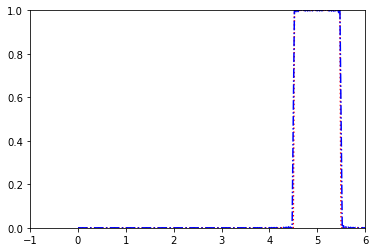

In [15]:
# set up animation plots
fig, ax = plt.subplots()
ax.axis([-1,6,0,1])
def animate(i):
    l.set_data(x, U[:,i])
    m.set_data(x,U_ex[:,i])
    
ax.axis([-1,11,0,1])
l, = ax.plot([],[],':r')
m, = ax.plot([],[],'-.b')

ani2 = matplotlib.animation.FuncAnimation(fig, animate, frames=Nt_points)

from IPython.display import HTML
HTML(ani2.to_jshtml())

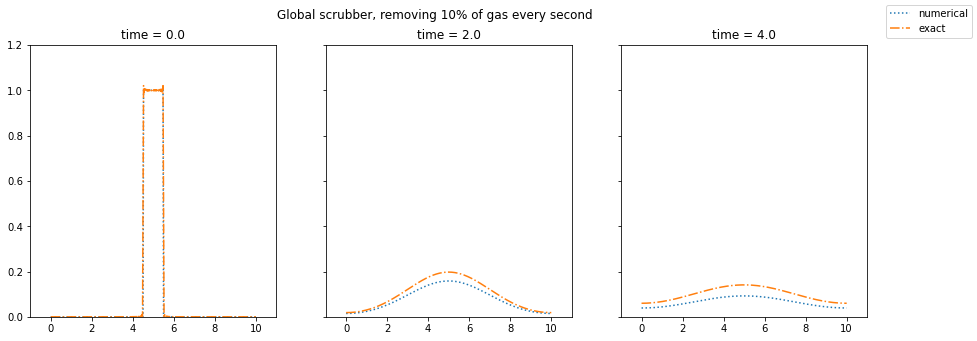

In [6]:
times = np.linspace(0, Nt_gaps, 3, dtype = int)

fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize = (15, 5))


ax[0].axis([-1, 11, 0, 1.2])
ax[1].axis([-1, 11, 0, 1.2])
ax[2].axis([-1, 11, 0, 1.2])

ax[0].plot(x, U[:, times[0]], ':', label = 'numerical')
ax[0].plot(x, U_ex[:, times[0]], '-.', label = 'exact')
ax[0].set_title(f'time = {t[times[0]]}')

ax[1].plot(x, U[:, times[1]], ':')
ax[1].plot(x, U_ex[:, times[1]], '-.')
ax[1].set_title(f'time = {t[times[1]]}')

ax[2].plot(x, U[:, times[2]], ':')
ax[2].plot(x, U_ex[:, times[2]], '-.')
ax[2].set_title(f'time = {t[times[2]]}')

fig.suptitle('Global scrubber, removing 10% of gas every second')
fig.legend()
#plt.tight_layout()